# 1. Imports 

In [1]:
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v3.csv')

# 2. Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training with unscaled data

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

# TODO: Probar con los datos sin normalizar
#normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [5]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 139, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 139, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 139, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 32)           0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 47, 64)            4160      
                                                             

In [6]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=30)

Epoch 1/30
459/459 [==============================] - 8s 10ms/step - loss: 0.0547 - MAE: 0.1785 - val_loss: 0.0368 - val_MAE: 0.1536
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0201 - MAE: 0.1029 - val_loss: 0.0134 - val_MAE: 0.0840
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0123 - MAE: 0.0803 - val_loss: 0.0089 - val_MAE: 0.0664
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0089 - MAE: 0.0664 - val_loss: 0.0072 - val_MAE: 0.0552
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0075 - MAE: 0.0603 - val_loss: 0.0055 - val_MAE: 0.0522
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0048 - MAE: 0.0480 - val_loss: 0.0043 - val_MAE: 0.0447
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0047 - MAE: 0.0475 - val_loss: 0.0034 - val_MAE: 0.0428
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0

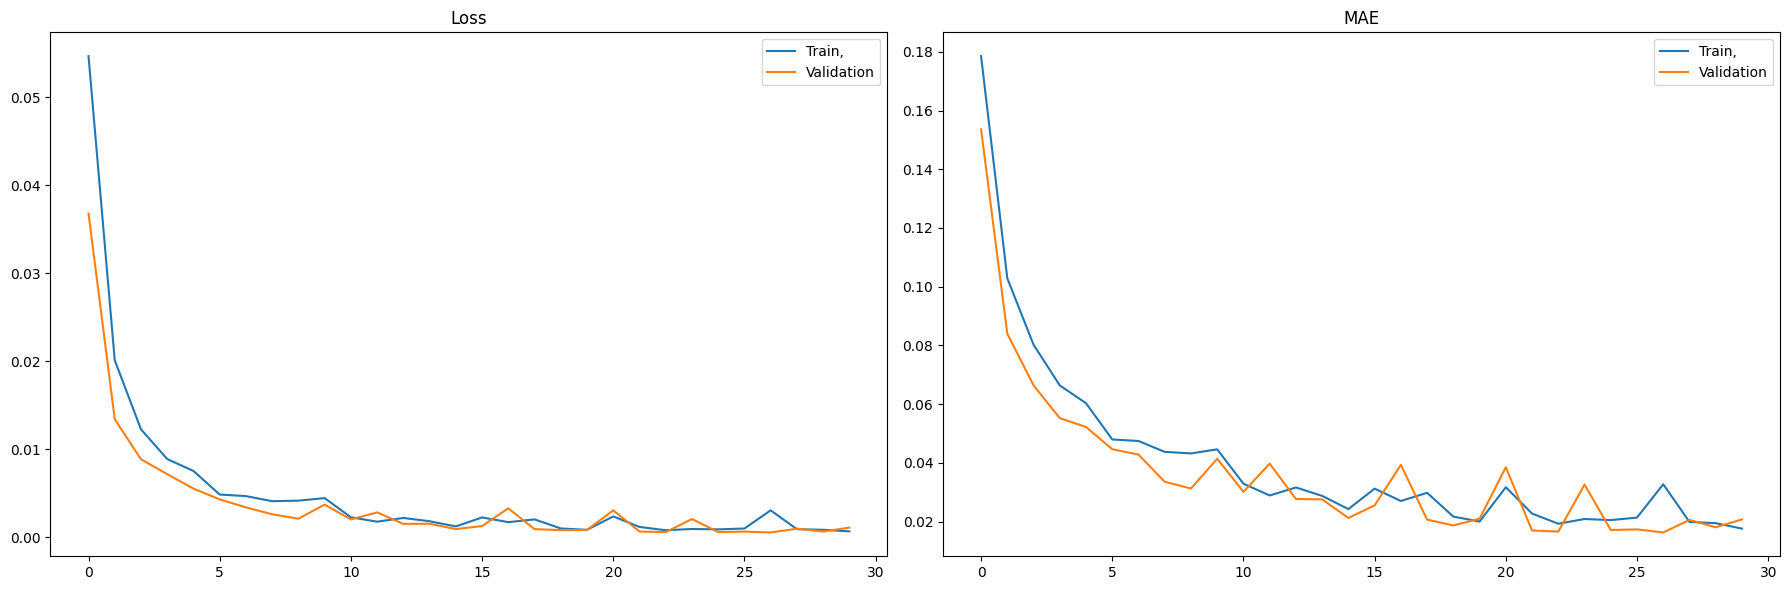

In [7]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(x_val, y_val)

print('loss: %.4f  MAE:%.4f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 0s 3ms/step - loss: 0.0011 - MAE: 0.0208
loss: 0.0011  MAE:0.0208


In [9]:
predictions = model.predict(x_test)

153/153 [==============================] - 0s 2ms/step


In [10]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.0027  MAE:0.0337
log g -       loss: 0.0005  MAE:0.0171
v -           loss: 0.0002  MAE:0.0123


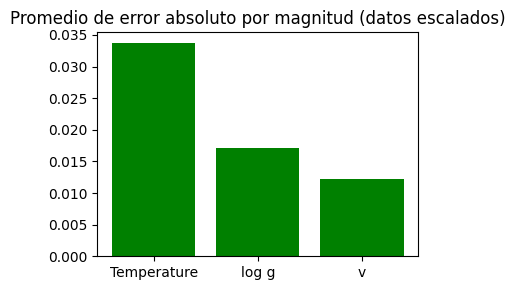

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(predictions-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [12]:
predictions = y_scaler.inverse_transform(predictions)

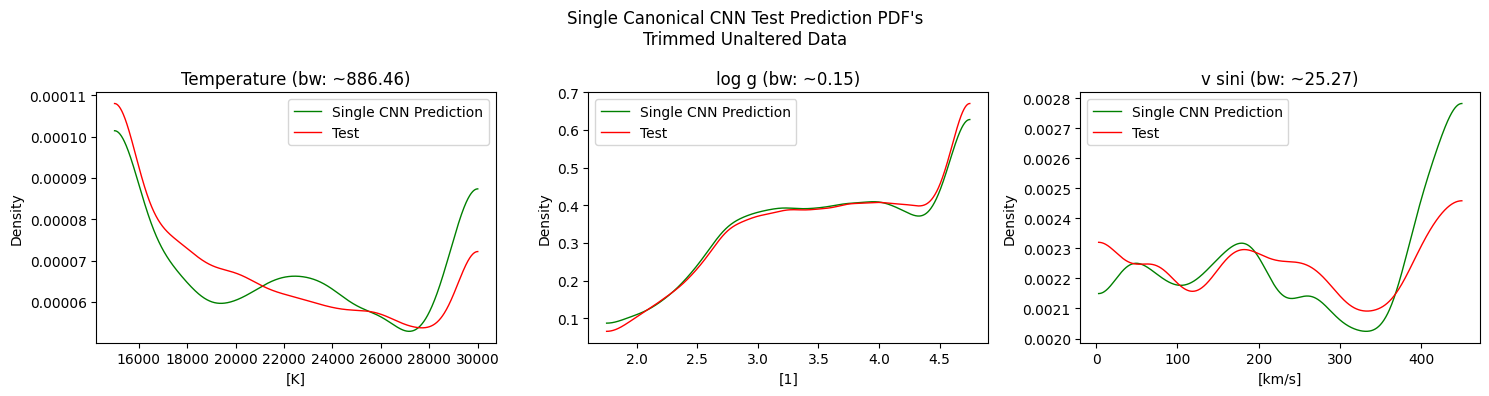

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title(measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.suptitle('Single Canonical CNN Test Prediction PDF\'s\nTrimmed Unaltered Data')
plt.legend()
plt.tight_layout();
plt.show()

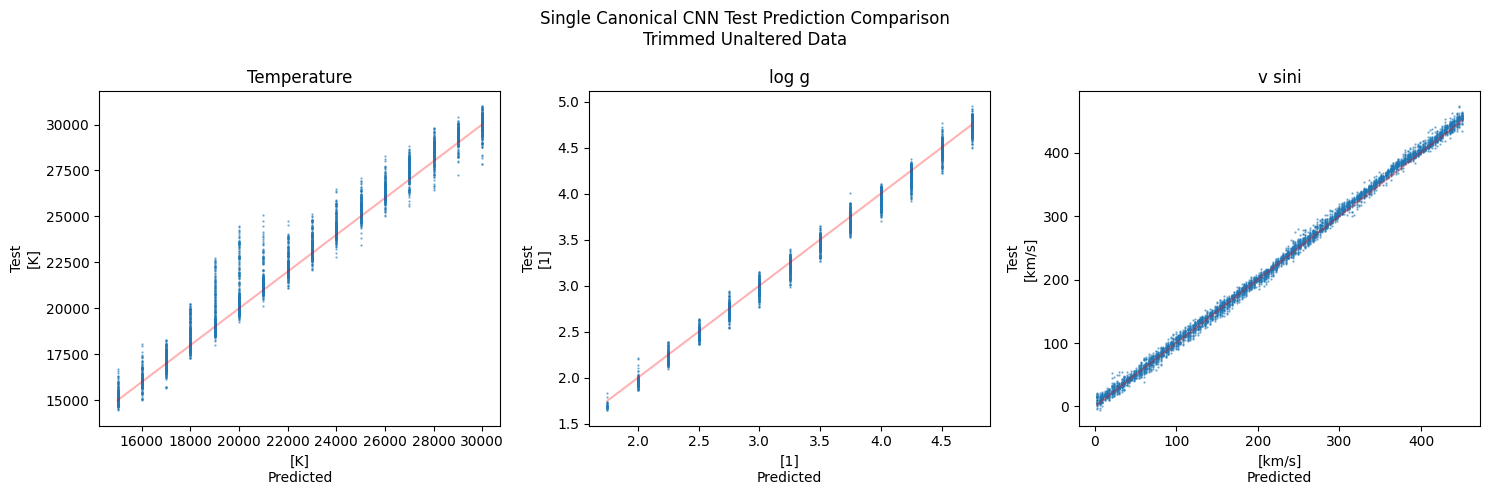

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Canonical CNN Test Prediction Comparison\nTrimmed Unaltered Data')
plt.tight_layout();
plt.show()

In [15]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [16]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17409,409 (2.4%),3.25,3.18,0.07 (2.0%),246,250,4 (1.7%)
1,18000,17498,502 (2.8%),2.75,2.75,0.0 (0.2%),285,285,0 (0.1%)
2,30000,30720,720 (2.4%),3.75,3.73,0.02 (0.6%),267,271,4 (1.7%)
3,23000,22535,465 (2.0%),2.5,2.43,0.07 (2.7%),63,67,4 (6.8%)
4,19000,18695,305 (1.6%),3.0,2.94,0.06 (2.1%),126,126,0 (0.1%)
5,17000,17341,341 (2.0%),4.5,4.54,0.04 (0.9%),156,156,0 (0.2%)
6,28000,27267,733 (2.6%),3.25,3.16,0.09 (2.8%),450,456,6 (1.4%)
7,22000,22424,424 (1.9%),4.0,3.94,0.06 (1.4%),285,288,3 (1.1%)
8,23000,22664,336 (1.5%),3.0,2.98,0.02 (0.8%),30,29,1 (2.8%)
9,23000,22701,299 (1.3%),4.5,4.49,0.01 (0.3%),153,151,2 (1.6%)


## Datos Observados

In [17]:
predictions = model.predict(x_obs)

8/8 [==============================] - 0s 36ms/step


In [18]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.253  MAE:0.400
log g -       loss: 0.131  MAE:0.232
v -           loss: 0.042  MAE:0.162


In [19]:
predictions = y_scaler.inverse_transform(predictions)

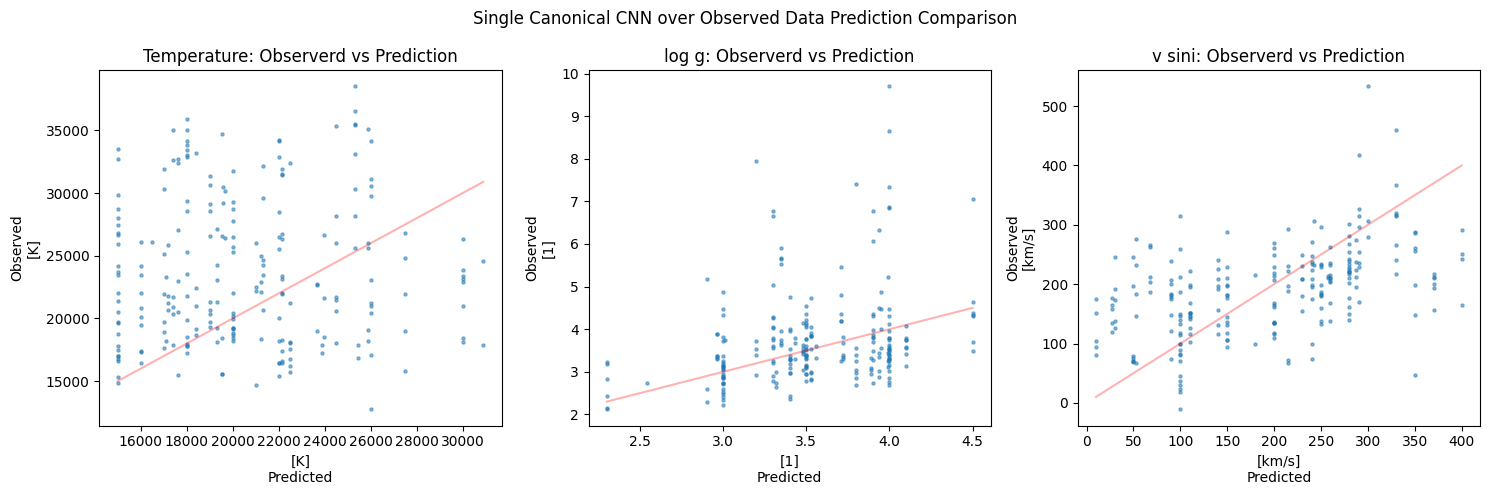

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Canonical CNN over Observed Data Prediction Comparison')
plt.tight_layout();
plt.show()

# 4. Training with scaled data

In [45]:
x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [46]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 

model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=20)

Epoch 1/20
459/459 [==============================] - 4s 8ms/step - loss: 0.0552 - MAE: 0.1800 - val_loss: 0.0313 - val_MAE: 0.1253
Epoch 2/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0236 - MAE: 0.1120 - val_loss: 0.0165 - val_MAE: 0.0997
Epoch 3/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0136 - MAE: 0.0840 - val_loss: 0.0095 - val_MAE: 0.0729
Epoch 4/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0093 - MAE: 0.0684 - val_loss: 0.0071 - val_MAE: 0.0637
Epoch 5/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0068 - MAE: 0.0583 - val_loss: 0.0059 - val_MAE: 0.0550
Epoch 6/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0047 - MAE: 0.0487 - val_loss: 0.0033 - val_MAE: 0.0422
Epoch 7/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0039 - MAE: 0.0444 - val_loss: 0.0044 - val_MAE: 0.0475
Epoch 8/20
459/459 [==============================] - 3s 7ms/step - loss: 0.

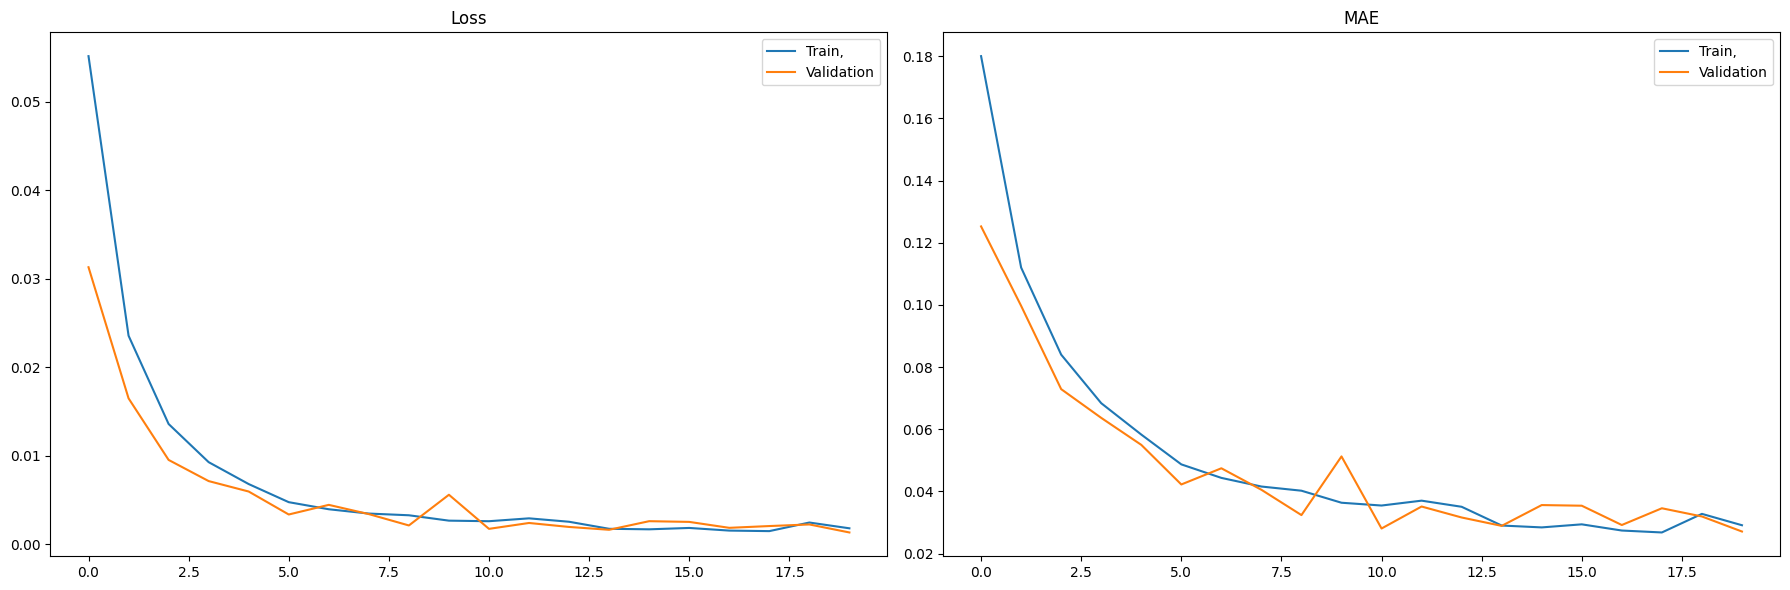

In [47]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [54]:
predictions = y_scaler.inverse_transform(model.predict(x_test))

153/153 [==============================] - 0s 3ms/step


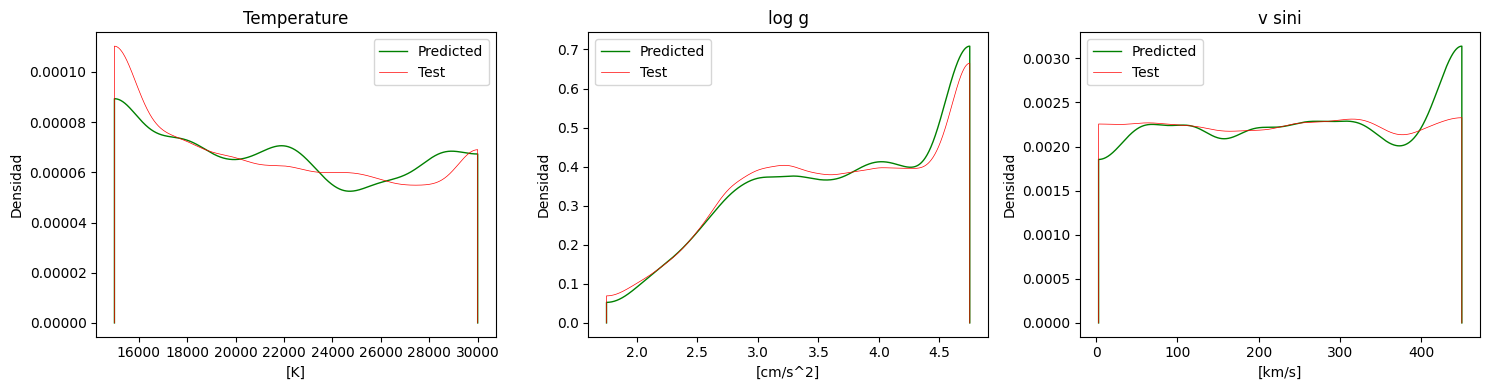

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	SKL_density_plot(predictions[:,i], axes[i], featureName, low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], featureName, low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',linewidth=0.5,label='Test')
	axes[i].set_title(target[i])
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[cm/s^2]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title(measure[i])
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

In [57]:
predictions = y_scaler.inverse_transform(model.predict(X_obs))
results = Y_obs.join(pd.DataFrame(predictions, columns = ['pred_temperature','pred_g','pred_v']))
results

1/1 [==============================] - 0s 109ms/step


,temperature,g,v,pred_temperature,pred_g,pred_v
0,15000.0,3.40,68.0,14893.186523,1.779167,161.899124
1,18400.0,3.50,40.0,17352.154297,2.177631,190.399826
2,30000.0,3.53,150.0,17723.097656,2.009917,163.740158
3,22000.0,3.90,280.0,17587.363281,2.071330,229.627121
4,24500.0,3.40,215.0,15611.905273,2.050298,199.987534
5,22000.0,3.50,180.0,19729.789062,2.312148,191.681580
6,20000.0,3.56,10.0,18146.845703,2.216581,157.516022
7,18000.0,3.53,250.0,18553.900391,2.326026,188.902771
8,26000.0,2.90,300.0,15303.413086,1.944731,138.457565


# 5. Scaled Data and Noise addition

In [58]:
x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)

In [59]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 

model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=20)

Epoch 1/20
459/459 [==============================] - 4s 8ms/step - loss: 0.0541 - MAE: 0.1762 - val_loss: 0.0205 - val_MAE: 0.1055
Epoch 2/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0176 - MAE: 0.0971 - val_loss: 0.0172 - val_MAE: 0.0942
Epoch 3/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0134 - MAE: 0.0823 - val_loss: 0.0119 - val_MAE: 0.0739
Epoch 4/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0101 - MAE: 0.0698 - val_loss: 0.0066 - val_MAE: 0.0574
Epoch 5/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0073 - MAE: 0.0596 - val_loss: 0.0054 - val_MAE: 0.0484
Epoch 6/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0055 - MAE: 0.0516 - val_loss: 0.0048 - val_MAE: 0.0512
Epoch 7/20
459/459 [==============================] - 3s 7ms/step - loss: 0.0046 - MAE: 0.0469 - val_loss: 0.0071 - val_MAE: 0.0613
Epoch 8/20
459/459 [==============================] - 3s 7ms/step - loss: 0.

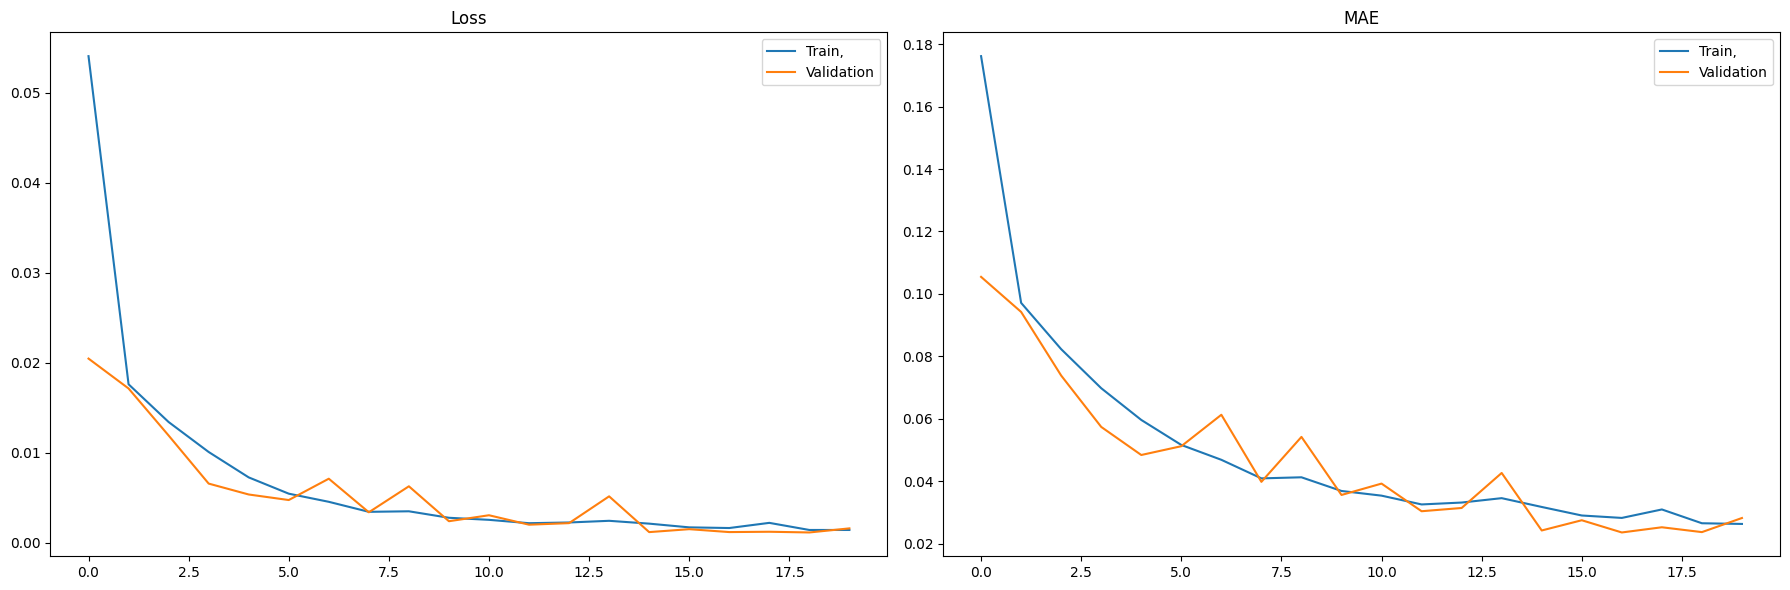

In [60]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [61]:
predictions = y_scaler.inverse_transform(model.predict(x_test))

153/153 [==============================] - 0s 2ms/step


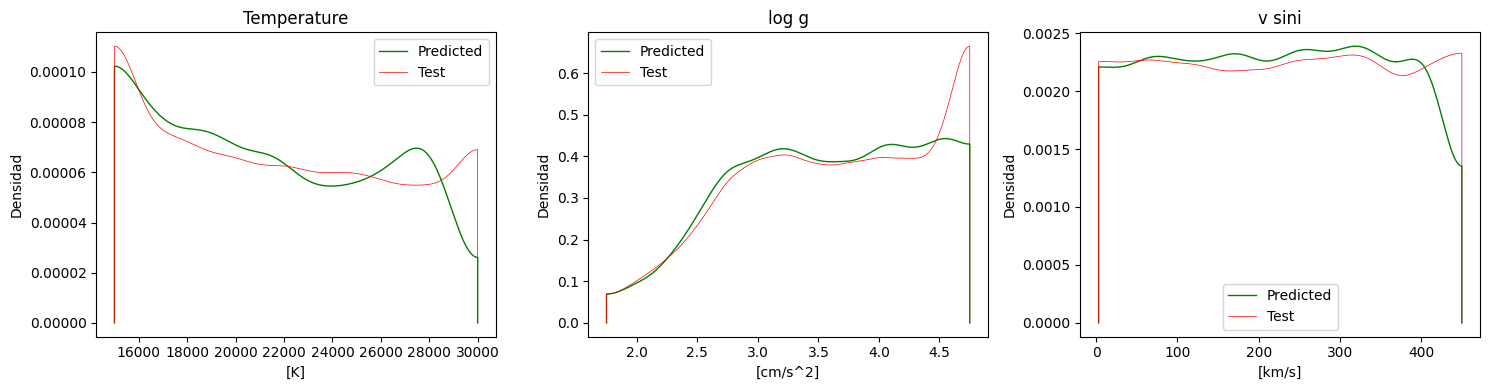

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	SKL_density_plot(predictions[:,i], axes[i], featureName, low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], featureName, low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',linewidth=0.5,label='Test')
	axes[i].set_title(target[i])
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[cm/s^2]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title(measure[i])
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

In [63]:
predictions = y_scaler.inverse_transform(model.predict(X_obs))
results = Y_obs.join(pd.DataFrame(predictions, columns = ['pred_temperature','pred_g','pred_v']))
results

1/1 [==============================] - 0s 110ms/step


,temperature,g,v,pred_temperature,pred_g,pred_v
0,15000.0,3.40,68.0,12491.278320,1.758611,155.835510
1,18400.0,3.50,40.0,16519.902344,2.031187,217.447266
2,30000.0,3.53,150.0,13715.803711,1.759559,188.502808
3,22000.0,3.90,280.0,15190.629883,2.046773,202.758224
4,24500.0,3.40,215.0,13700.939453,2.024369,185.065094
5,22000.0,3.50,180.0,14547.498047,1.908791,193.445602
6,20000.0,3.56,10.0,15806.042969,2.002166,155.472809
7,18000.0,3.53,250.0,14835.726562,1.987709,205.298279
8,26000.0,2.90,300.0,11146.535156,2.023316,78.091972
